# NTM Model Creation

ToDo:
- Make a function for creating a corpus
- Make a function for vectorizing
- Make a visualization of each topic
- 80% Train 10% Test 10% Validate

## Env

In [1]:
from io import StringIO
import os
import random

import boto3
import pandas as pd
import numpy as np
import nltk

from sagemaker import Session, get_execution_role
from sagemaker.amazon import common as smac
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve
from sagemaker.inputs import TrainingInput
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sklearn.feature_extraction.text import CountVectorizer

import nlp_utils as nlpu

Set up NLTK tools

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Global Variables

In [3]:
# Sagemaker Session info
sess = Session(default_bucket='ntm-model-capstone-data')

# Input/Output
bucket = sess.default_bucket()
SOURCE_DATA_PATH = "raw"
ARTIFACT_PATH = "arp_ml_artifacts"

# Data Prep
MAX_FREQ = 0.9
MIN_FREQ = 0.01

# Modeling
NUM_TOPICS=10
MINI_BATCH_SIZE=300
EPOCHS=70
SUB_SAMPLE=0.7
INSTANCE_COUNT=12
TRAIN_PERCENT = 0.8

# AWS
s3 = boto3.resource('s3')
sm_role = get_execution_role()
region = boto3.Session().region_name

---

## Data Ingestion
Read in data from S3

In [4]:
amzn_reviews = pd.read_csv(f"s3://{bucket}/{SOURCE_DATA_PATH}/amzn_reviews.csv", header=None)
cols = ["pole", "title", "review"]
amzn_reviews.columns = cols
amzn_reviews.head(3)

,pole,title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...


Filter out negative reviews

In [5]:
neg_reviews = amzn_reviews[amzn_reviews.pole == 1]
del(amzn_reviews)
neg_reviews.head(3)

,pole,title,review
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
5,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...
6,1,Incorrect Disc,"I love the style of this, but after a couple y..."


Create a list of documents for the training data and the test data

In [6]:
input_data = neg_reviews.review.to_numpy()
del(neg_reviews)

---

## Data Prepare

Shuffle each dataset, just to ensure the document order doesn't affect the model

In [7]:
random.seed(42)
random.shuffle(input_data)

Some document entries may not contain enough words to impact our model.   
We should remove any review with fewer than 50 words.

In [8]:
trimmed_input = [doc for doc in input_data if len(doc) >= 50]
del(input_data)

There are 2 million entries in our negative review input data set   
We should try to make our validation set the same size as the test set. Usually, data is split between 80% training and 20% for validation/test.   
The data has already been shuffled, so we can be reasonably sure that splitting the data at calculated intervals will result in a validation_set that is representative of our test set.   
This should leave us with a validation_set and test_set that are roughly 10% the size of the train_set.   
We will extract 5 entries for a demonstration at the end.   

In [9]:
split = int(TRAIN_PERCENT * len(trimmed_input))
remainder_len = len(trimmed_input[split:])//2

train_set = trimmed_input[:split]
validation_set = trimmed_input[split:-remainder_len]
test_set = trimmed_input[-remainder_len:-5]
demo_set = trimmed_input[-5:]

In [10]:
print("Lengths:")
print(f"Val   - {len(validation_set)}")
print(f"Train - {len(train_set)}")
print(f"Test  - {len(test_set)}")
print(f"Demo  - {len(demo_set)}")

Lengths:
Val   - 199987
Train - 1599892
Test  - 199981
Demo  - 5


Write the demo_set to S3 as individual document files.

In [11]:
for i, doc in enumerate(demo_set):
    demo_file = StringIO(doc)
    s3.Object(bucket, f"{ARTIFACT_PATH}/data/csv/demo/document_{i+1}.txt").put(Body=demo_file.getvalue())

---

## Data Processing

In [12]:
vectorizer = CountVectorizer(input='content',
                             analyzer='word',
                             stop_words='english',
                             tokenizer=nlpu.Lemmatizer(),
                             max_df=MAX_FREQ,
                             min_df=MIN_FREQ,
                             dtype=np.float32)

The fit_transform() method will help create our vocab list.   

In [13]:
# This step can take awhile. Get a cup of coffee.

train_vectorized = vectorizer.fit_transform(train_set)
val_vectorized = vectorizer.transform(validation_set)
test_vectorized = vectorizer.transform(test_set)
demo_vectorized = vectorizer.transform(demo_set)

In [14]:
del(train_set)
del(validation_set)
del(test_set)
del(demo_set)

In [15]:
# Demo data needs to be in csv format later to input into batch transformation
demo_buffer = StringIO()
demo_df = pd.DataFrame(demo_vectorized.toarray())
demo_df.to_csv(demo_buffer, index=False, header=False)
s3.Object(bucket, f"{ARTIFACT_PATH}/demo.csv").put(Body=demo_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '314DF3C108B97976',
  'HostId': 'hAa8bWpFBnCvpbFDlyLdGZ5lwYflf2qHXuUnf06vigljCMWoYShlW1uxzqDMegPp8epIpqcbsus=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'hAa8bWpFBnCvpbFDlyLdGZ5lwYflf2qHXuUnf06vigljCMWoYShlW1uxzqDMegPp8epIpqcbsus=',
   'x-amz-request-id': '314DF3C108B97976',
   'date': 'Wed, 20 Jan 2021 16:36:30 GMT',
   'x-amz-version-id': 'UlF0EojqWj5PwRRudZ_ydGnUth3TopAq',
   'etag': '"ad4d04fb83f4700b192b3ad1e5b79571"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"ad4d04fb83f4700b192b3ad1e5b79571"',
 'VersionId': 'UlF0EojqWj5PwRRudZ_ydGnUth3TopAq'}

In [16]:
vocab = vectorizer.get_feature_names()

print(f"Vocabulary size: {len(vocab)} words")
print(f"Train Shape: {train_vectorized.shape}")
print(f"Test Shape: {test_vectorized.shape}")
print(f"Validate Shape: {val_vectorized.shape}")
print(f"Demo Shape: {demo_vectorized.shape}")

# upload vocab file to S3
vocab_file = StringIO("\n".join(vocab))
s3.Object(bucket, f"{ARTIFACT_PATH}/vocab.txt").put(Body=vocab_file.getvalue())

Vocabulary size: 524 words
Train Shape: (1599892, 524)
Test Shape: (199981, 524)
Validate Shape: (199987, 524)
Demo Shape: (5, 524)


{'ResponseMetadata': {'RequestId': '35120F2BAB6A4F72',
  'HostId': 'tGSGpgQDw9hZZkV6RkmrdNS0K1EJLWsMip170XzgE8LtqkUoWnCfYWiUR/VgdQASRo8vSwDXzLQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'tGSGpgQDw9hZZkV6RkmrdNS0K1EJLWsMip170XzgE8LtqkUoWnCfYWiUR/VgdQASRo8vSwDXzLQ=',
   'x-amz-request-id': '35120F2BAB6A4F72',
   'date': 'Wed, 20 Jan 2021 16:36:35 GMT',
   'x-amz-version-id': '6.UPxrZJBS5v6YXKcMT0Ghe_hhECGLVU',
   'etag': '"8d331ec957b40a1b5077f4d7480e3466"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8d331ec957b40a1b5077f4d7480e3466"',
 'VersionId': '6.UPxrZJBS5v6YXKcMT0Ghe_hhECGLVU'}

#### Upload prepared data

In [17]:
# upload training set
try:
    nlpu.recordize(train_vectorized, bucket, f"{ARTIFACT_PATH}/data/recordio/train", parts=INSTANCE_COUNT)
except Exception as e:
    print(e)

# upload validation set
try:
    nlpu.recordize(val_vectorized, bucket, f"{ARTIFACT_PATH}/data/recordio/val", parts=1)
except Exception as e:
    print(e)

# upload test set
try:
    nlpu.recordize(test_vectorized, bucket, f"{ARTIFACT_PATH}/data/recordio/test", parts=1)
except Exception as e:
    print(e)

Uploading data to S3:
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_0.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_1.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_2.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_3.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_4.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_5.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_6.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_7.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_8.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_9.pbr
    s3://ntm-model-capstone-data/arp_ml_artifacts/data/recordio/train/data_part_10.pbr
    s3://ntm-model-capstone-dat

## Train Model
Create Estimator object

In [18]:
container = retrieve('ntm', region, image_scope='training')
ntm_model = Estimator(container,
                      sm_role,
                      instance_count=INSTANCE_COUNT,
                      instance_type='ml.m4.xlarge', # 'ml.g4dn.xlarge' AWS recommends GPU instances for training NTM models
                      use_spot_instances=True,
                      max_wait=900,
                      max_run=900,
                      volume_size = 5,
                      output_path=f"s3://{bucket}/{ARTIFACT_PATH}/model",
                      sagemaker_session=sess)

Set hyperparameters

In [19]:
ntm_model.set_hyperparameters(
    num_topics=NUM_TOPICS,
    feature_dim=len(vocab),
    mini_batch_size=MINI_BATCH_SIZE,
    epochs=EPOCHS,
    sub_sample=SUB_SAMPLE)

Define training input channels

In [20]:
train_data = TrainingInput(f"s3://{bucket}/{ARTIFACT_PATH}/data/recordio/train",
                                            s3_data_type="S3Prefix",
                                            content_type="application/x-recordio-protobuf",
                                            distribution="ShardedByS3Key")

validation_data = TrainingInput(f"s3://{bucket}/{ARTIFACT_PATH}/data/recordio/val",
                                                 content_type="application/x-recordio-protobuf",
                                                 distribution="FullyReplicated")

test_data = TrainingInput(f"s3://{bucket}/{ARTIFACT_PATH}/data/recordio/test",
                                           content_type="application/x-recordio-protobuf",
                                           distribution="FullyReplicated")

aux_data = TrainingInput(f"s3://{bucket}/{ARTIFACT_PATH}/vocab.txt",
                                          content_type="text/plain",
                                          distribution="FullyReplicated")

data_channels = {
    'train': train_data,
    'validation': validation_data,
    'test': test_data,
    'auxiliary': aux_data
}

Train a model

In [22]:
ntm_model.fit(job_name='ntm-train-32',
              inputs=data_channels,
              logs=True)

2021-01-20 16:40:12 Starting - Starting the training job...
2021-01-20 16:40:34 Starting - Launching requested ML instancesProfilerReport-1611160811: InProgress
.........
2021-01-20 16:41:55 Starting - Preparing the instances for training...............
2021-01-20 16:44:44 Downloading - Downloading input data
2021-01-20 16:44:44 Training - Downloading the training image...Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argumen

## Batch Inference

In [ ]:
# ntm_transformer = ntm_model.transformer(instance_count=1,
#                                         instance_type="ml.m4.xlarge",
#                                         strategy="MultiRecord",
#                                         assemble_with="Line",
#                                         output_path=f"s3://{bucket}/{ARTIFACT_PATH}")

In [ ]:
# ntm_transformer.transform(f"s3://{bucket}/{ARTIFACT_PATH}/demo.csv", content_type='text/csv', split_type='Line')

## Model Endpoint

In [23]:
ntm_predictor = ntm_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------------!

In [24]:
ntm_predictor.serializer = CSVSerializer()
ntm_predictor.deserializer = JSONDeserializer()

In [25]:
results = ntm_predictor.predict(demo_vectorized.toarray(), initial_args={"ContentType": "text/csv"})
print(results)

{'predictions': [{'topic_weights': [0.1032734141, 0.098034814, 0.099005051, 0.0988119394, 0.0994699672, 0.1018297747, 0.100455977, 0.0989081562, 0.09878961, 0.1014212072]}, {'topic_weights': [0.1032977551, 0.0980389044, 0.0990143791, 0.0988144204, 0.09947633, 0.1018188596, 0.1004527882, 0.0989025831, 0.0987693146, 0.1014146879]}, {'topic_weights': [0.1032976508, 0.098038882, 0.0990143418, 0.0988144204, 0.09947633, 0.1018188894, 0.1004527733, 0.0989025906, 0.0987693891, 0.1014147177]}, {'topic_weights': [0.1032729968, 0.0980347395, 0.09900482, 0.0988118798, 0.0994699001, 0.1018298939, 0.1004560068, 0.0989083275, 0.0987899676, 0.1014214307]}, {'topic_weights': [0.1032997072, 0.0980392173, 0.099015139, 0.0988146067, 0.099476859, 0.101817973, 0.1004525274, 0.0989021286, 0.0987676755, 0.1014141664]}]}


In [26]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.10327341 0.09803481 0.09900505 0.09881194 0.09946997 0.10182977
  0.10045598 0.09890816 0.09878961 0.10142121]
 [0.10329776 0.0980389  0.09901438 0.09881442 0.09947633 0.10181886
  0.10045279 0.09890258 0.09876931 0.10141469]
 [0.10329765 0.09803888 0.09901434 0.09881442 0.09947633 0.10181889
  0.10045277 0.09890259 0.09876939 0.10141472]
 [0.103273   0.09803474 0.09900482 0.09881188 0.0994699  0.10182989
  0.10045601 0.09890833 0.09878997 0.10142143]
 [0.10329971 0.09803922 0.09901514 0.09881461 0.09947686 0.10181797
  0.10045253 0.09890213 0.09876768 0.10141417]]


In [37]:
Session().delete_endpoint(ntm_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---

## Model Investigation

In [27]:
!pip install mxnet wordcloud

     |████████████████████████████████| 55.0 MB 60 kB/s s eta 0:00:01
     |████████████████████████████████| 366 kB 100.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [28]:
import matplotlib.pyplot as plt

import pandas as pd

import wordcloud as wc
import mxnet as mx

In [29]:
model_s3_path = f"{ARTIFACT_PATH}/model/{ntm_model._current_job_name}/output/model.tar.gz"
print(f"Model location in S3: {model_s3_path}")

Model location in S3: arp_ml_artifacts/model/ntm-train-32/output/model.tar.gz


In [30]:
boto3.resource('s3').Bucket(bucket).download_file(model_s3_path, 'downloaded_model.tar.gz')

In [31]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-9
model_algo-2
model_algo-8
model_algo-4
model_algo-3
model_algo-11
model_algo-5
model_algo-10
model_algo-7
model_algo-6
model_algo-12
model_algo-1


In [32]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [33]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

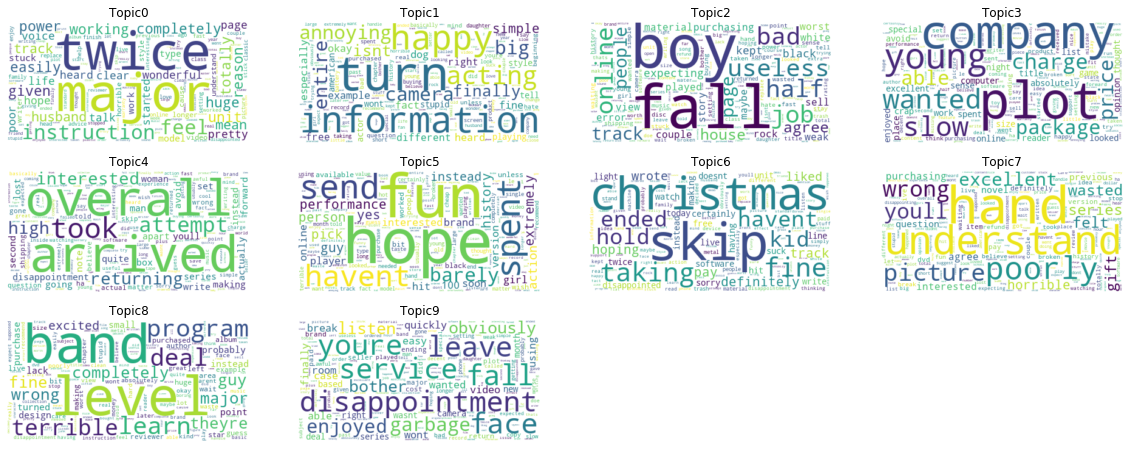

In [34]:
word_to_id = dict()
for i, v in enumerate(vocab):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(NUM_TOPICS):

    if counter >= limit:
        break

    title_str = f"Topic{ind}"

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1